In [1]:
from baynes.model_utils import *
from baynes import probability
from baynes.plotter import FitPlotter
from baynes.analysis import standard_analysis, multithreaded_run, sensitivity_sweep
from baynes.toyMC import SpectraSampler
import pandas as pd
from cmdstanpy import CmdStanModel
import logging
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import cmdstanpy
from baynes import hdi
from collections import defaultdict



cmdstanpy.utils.get_logger().setLevel(logging.ERROR)

sns.set_style('ticks')
sns.set_context("notebook", font_scale=1.2)
plt.rc("axes.spines", top=False, right=False)


Number of events in ROI:  5930
[0, 2833, 0.0382458098197273, 6.8] [9.61754190e-01 4.46228623e-04 3.77995812e-02]


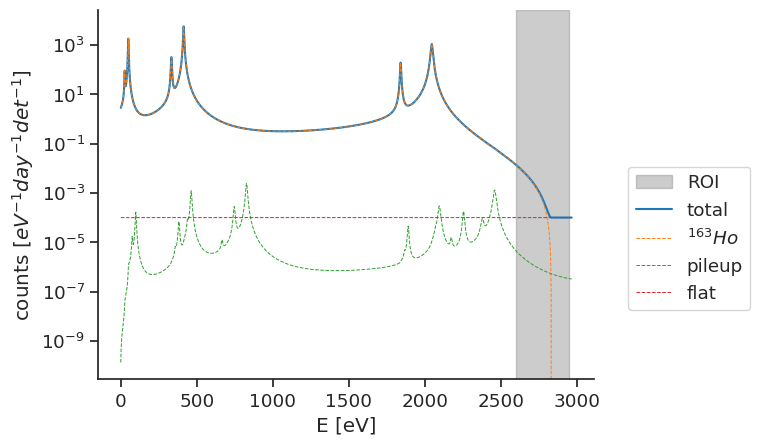

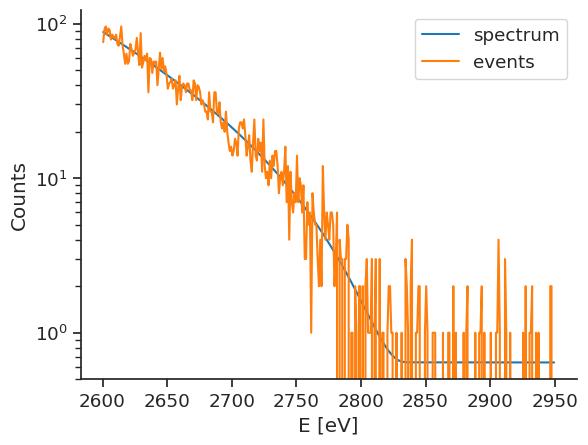

In [6]:
m = 0
Q = 2833
A_Ho = 1
bkg = 1e-4
pu = 1.5e-6
FWHM=6.8
n_det = 64
n_days = 100
ROI=[2600, 2950]
s = SpectraSampler({'$^{163}Ho$': [probability.HoSpectrum, [m, Q], A_Ho]}, flat_bkg=bkg, f_pileup=pu, FWHM=FWHM, dE=1, integrate=False, ROI=ROI)
s.plot_spectrum()
s.set_measure_time(n_days, n_det=n_det)

events = s.sample()[0]
s.plot_events(events)

true_pars = [m, Q, s.weights_in_ROI[2]+s.weights_in_ROI[1], s.FWHM]
print(true_pars, s.weights_in_ROI)

Found .stan file  /home/pietro/work/TESI/baynes/stan/models/163Ho/endpoint_simple/Ho_endpoint_simple.stan

 ---- Sampling the priors ---- 


 ---- Prior predictive check ---- 



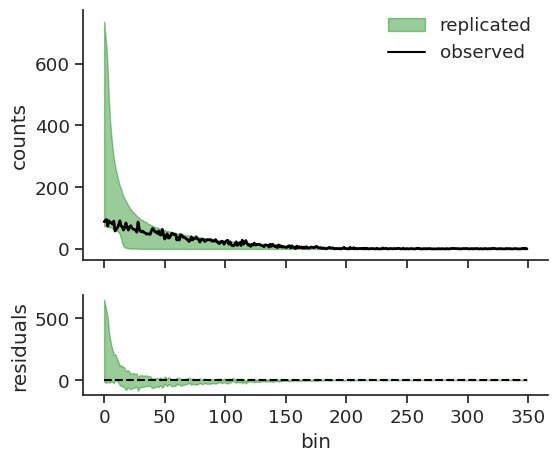


 ---- Prior distributions ---- 



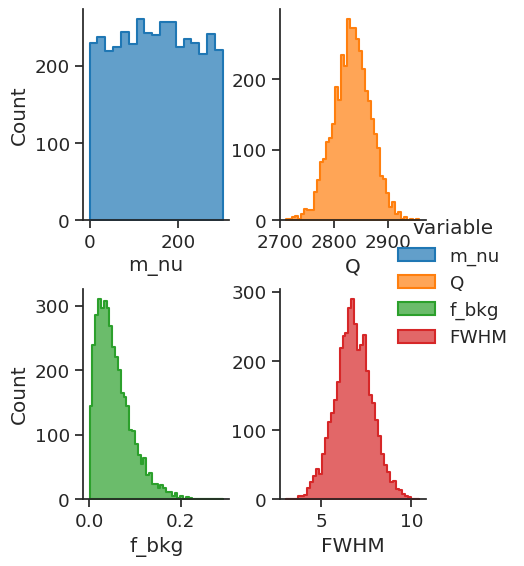


 ---- Fitting the model ---- 



chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

                                                                                                                                                                                                                                                                                                                                
Processing csv files: /tmp/tmpkgwfnt2l/Ho_endpoint_simples2hci9pw/Ho_endpoint_simple-20231003150732_1.csvWarning: non-fatal error reading adaptation data
, /tmp/tmpkgwfnt2l/Ho_endpoint_simples2hci9pw/Ho_endpoint_simple-20231003150732_2.csvWarning: non-fatal error reading adaptation data
, /tmp/tmpkgwfnt2l/Ho_endpoint_simples2hci9pw/Ho_endpoint_simple-20231003150732_3.csvWarning: non-fatal error reading adaptation data
, /tmp/tmpkgwfnt2l/Ho_endpoint_simples2hci9pw/Ho_endpoint_simple-20231003150732_4.csvWarning: non-fatal error reading adaptation data


Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for div

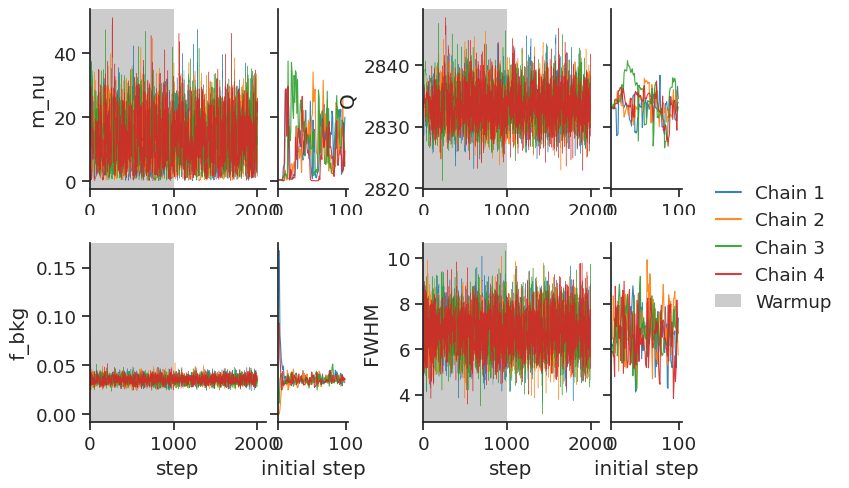


 ---- Posterior predictive check ---- 



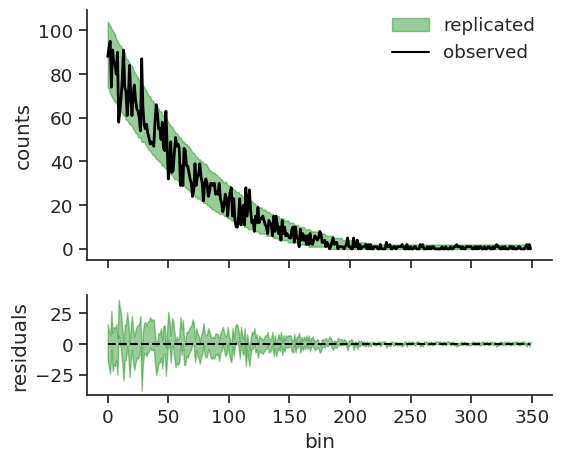


 ---- Posterior distributions ---- 



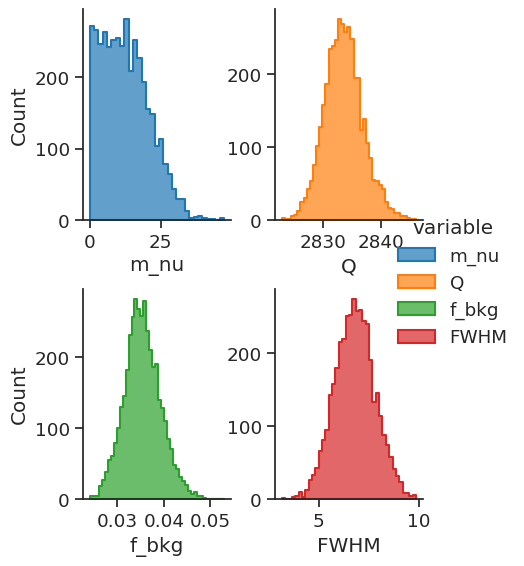


 ---- Prior vs posterior comparison ---- 



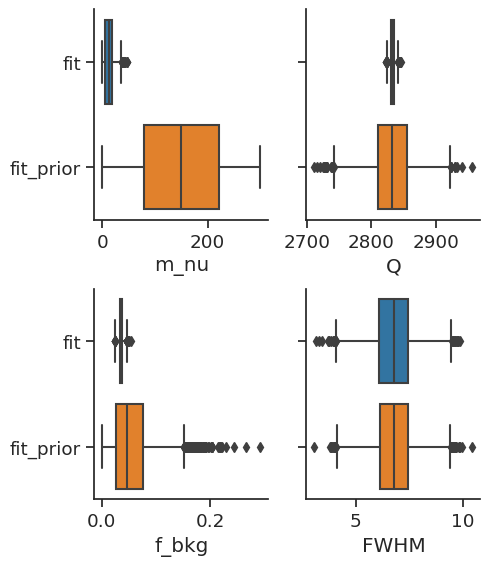

In [3]:
stan_file= get_stan_file("Ho_endpoint_simple.stan")
model = CmdStanModel(stan_file=stan_file,
                     **get_compiler_kwargs())

data={'N_bins': len(events), 
      'x': s.ROI_bin_edges, 
      'counts': events,
      'N_ev': s.n_events,
      'p_Q': 2833,
      'p_FWHM': FWHM,
      'm_max': 300
}

sampler_kwargs={
    'chains': 4,
   # 'iter_warmup': 600,
    #'iter_sampling': 1000,
    'save_warmup': True, 
   # 'max_treedepth': 11
    'inits': {'m_red': 0.001, 'z': 0, 'bkg': 0.004, 'FWHM': 6},
    'adapt_delta':0.95,
    #'show_console': True
}

plot_pars = ['m_nu', 'Q', 'f_bkg', 'FWHM']
p = FitPlotter(col_wrap=2, output_dir="/home/pietro/work/TESI/thesis/figures/ch3/endpoint/", output_format='.pdf')
fit = standard_analysis(model, data, p, sampler_kwargs=sampler_kwargs, plot_params=plot_pars)

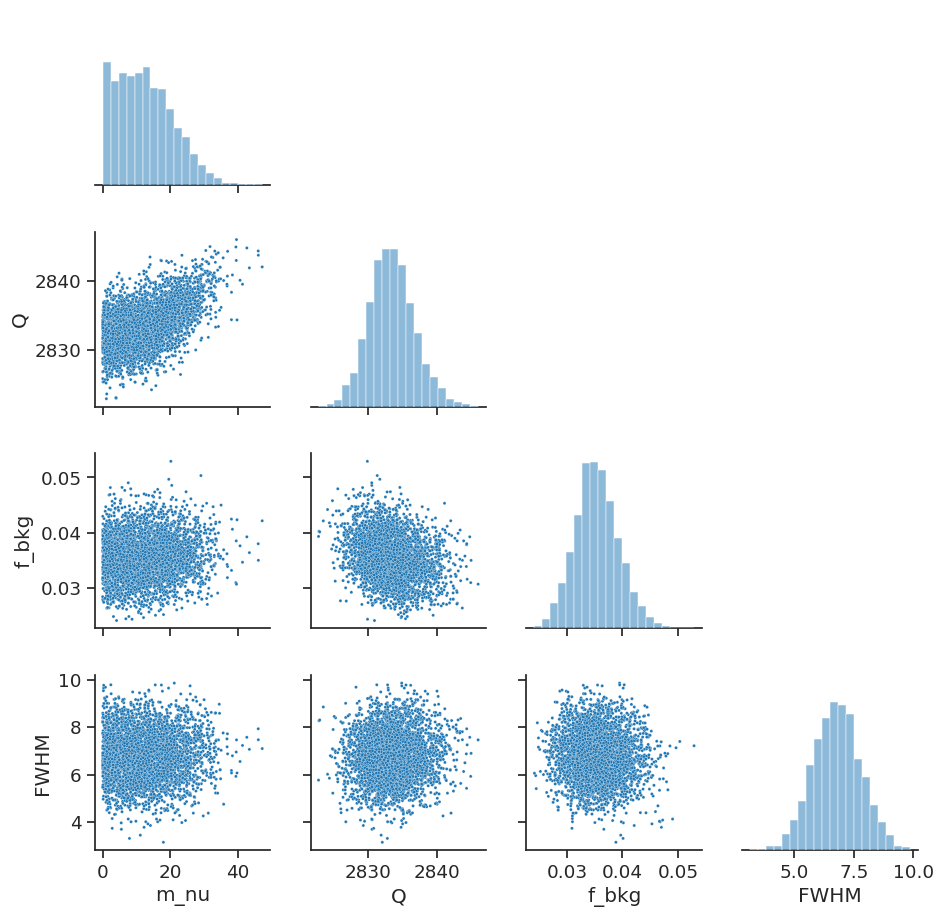

In [4]:
p.pair_grid(parameters=plot_pars, s=5)
p.resize(10,10)

<AxesSubplot: xlabel='m_max', ylabel='m_nu'>

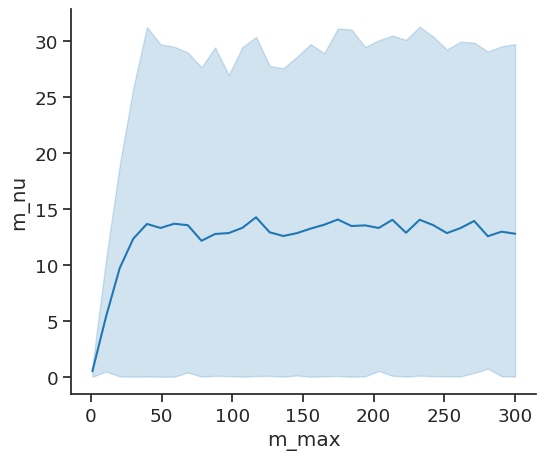

In [15]:
sampler_kwargs.update({'chains':1, 'show_progress':False})
res=sensitivity_sweep(model, data, {'m_max': np.linspace(1, 300, 32)}, parameters=['m_nu'], n_processes=32, sampler_kwargs=sampler_kwargs)
ax = p.new_figure('sensitivity').subplots()
sns.lineplot(res, x='m_max', y='m_nu', errorbar=hdi, ax=ax)

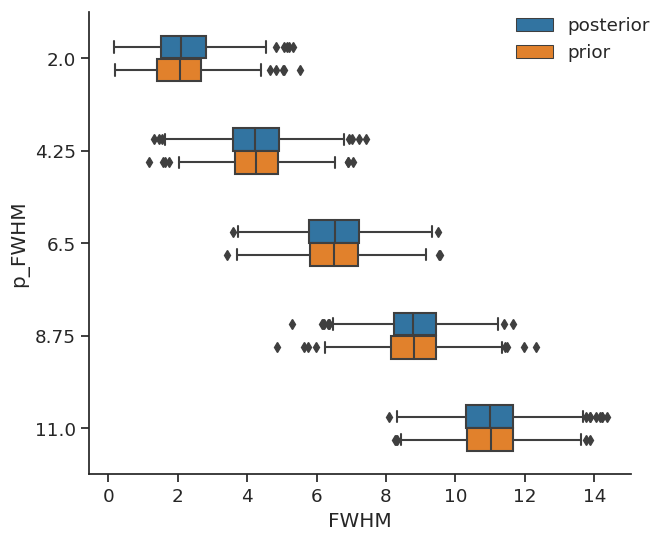

In [16]:
res=sensitivity_sweep(model, data, {'p_FWHM': np.linspace(2, 11, 5)}, parameters=['m_nu', 'FWHM'], n_processes=32, sampler_kwargs=sampler_kwargs)
res['fit'] ='posterior'

data['prior'] = 1
res2=sensitivity_sweep(model, data, {'p_FWHM': np.linspace(2, 11, 5)}, parameters=['m_nu', 'FWHM'], n_processes=32, sampler_kwargs=sampler_kwargs)
res2['fit'] ='prior'

res=pd.concat([res, res2])
ax = p.new_figure('sensitivity').subplots()
sns.boxplot(res, x='FWHM', y='p_FWHM', hue='fit', dodge=True, ax=ax, orient='h', width=0.5)
p.update_legend(edgecolor='white', bbox_to_anchor=(0.95,0.9))
p.resize(7,6)

In [5]:
p.save_figures('all')

In [102]:
sbc_model = CmdStanModel(stan_file=get_stan_file("Ho_endpoint_simple_SBC.stan"),
                     **get_compiler_kwargs())

Found .stan file  /home/pietro/work/TESI/baynes/stan/models/163Ho/endpoint_simple/Ho_endpoint_simple_SBC.stan


In [105]:
max_rank  = 100
thin=2
def run_SBC(model):
    data={'N_bins': len(events), 
      'x': s.ROI_bin_edges, 
      'N_ev': s.n_events,
      'p_Q': 2833,
      'p_FWHM': FWHM,
      'm_max': 250
    }    
    fit = model.sample(data,
                         chains=1,
                         iter_warmup=600,
                         iter_sampling=(max_rank-1)*thin,
                         show_progress=False,
                         adapt_delta=0.95,
                         inits= {'m_red': 0.001, 'z': 0, 'f_bkg': 0.04, 'FWHM': 6},
                         thin=thin)
    pars = ['m_nu', 'Q', 'f_bkg', 'FWHM']
    ranks = {}
    if sum(fit.divergences)!=0:
      print('there were', sum(fit.divergences), 'divergent transitions')
    for key in pars:
        df = fit.draws_pd('lt_'+key)
        ranks[key] = np.sum(df.to_numpy())
    return ranks
ranks = multithreaded_run(run_SBC, [sbc_model]*max_rank, 32)

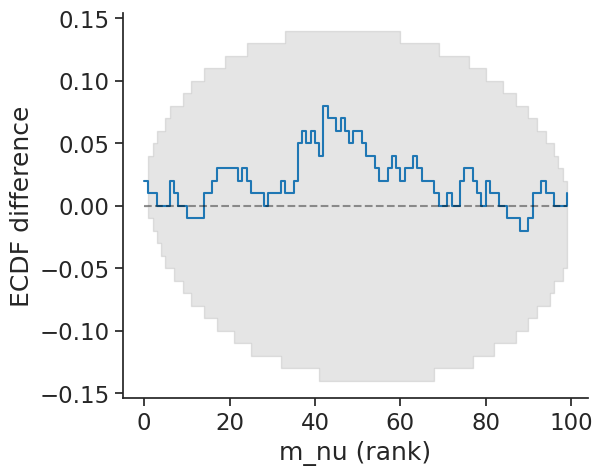

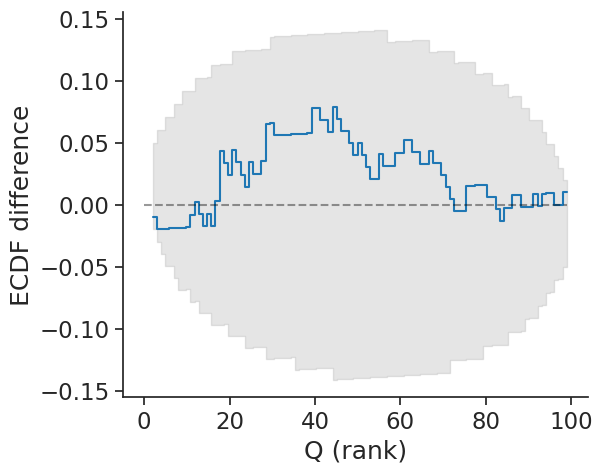

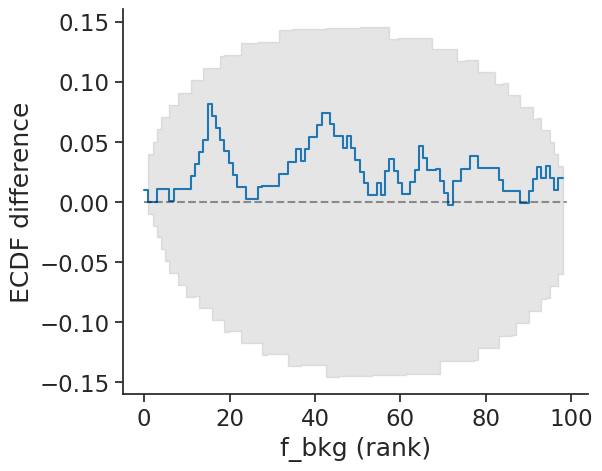

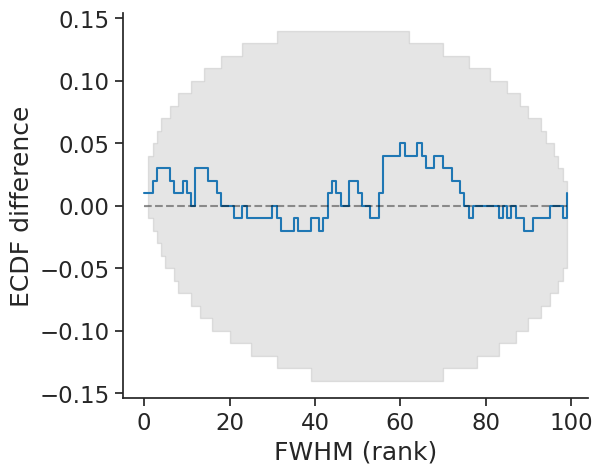

In [116]:
from collections import defaultdict

sns.set_context("notebook", font_scale=1.5)

dd = defaultdict(list)
for d in ranks: # you can list as many input dicts as you want here
    for key, value in d.items():
        dd[key].append(value)
    
pdf = stats.uniform(0,max_rank)
for par in dd.keys():
    ax = p.new_figure('SBC').subplots()
    ax = az.plot_ecdf(dd[par], cdf = pdf.cdf, difference=True, plot_kwargs={}, fill_kwargs={'color': 'grey'}, ax=ax)
    ax.set_xlabel(par+' (rank)')
    ax.set_ylabel('ECDF difference')
    ax.plot([0]*max_rank, ls='--', color='black', alpha=0.4)

In [112]:
import json
def save_dict_to_json(dd, file_path):
    with open(file_path, 'w') as json_file:
        json.dump(dd, json_file, indent=4)
    print(f"Dictionary saved to {file_path}")

file_path = "/home/pietro/work/TESI/baynes/data/endpoint/ranks.json"
save_dict_to_json(dd, file_path)

Dictionary saved to /home/pietro/work/TESI/baynes/data/endpoint/ranks.json


In [128]:
p.save_figures('all')

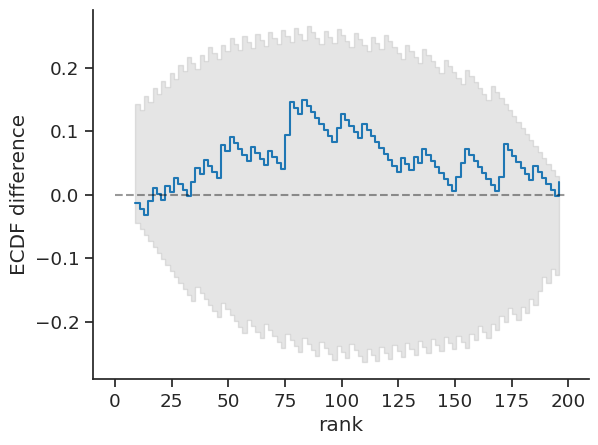

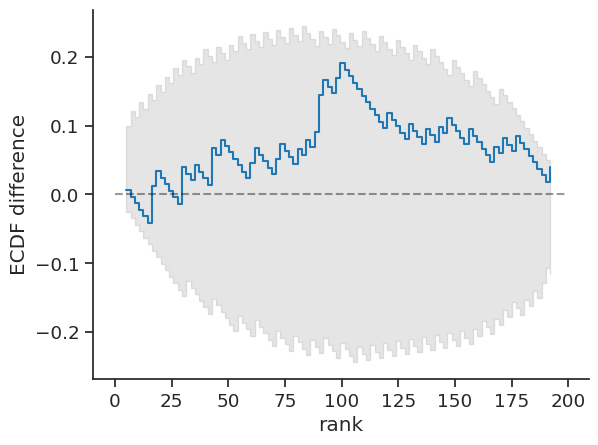

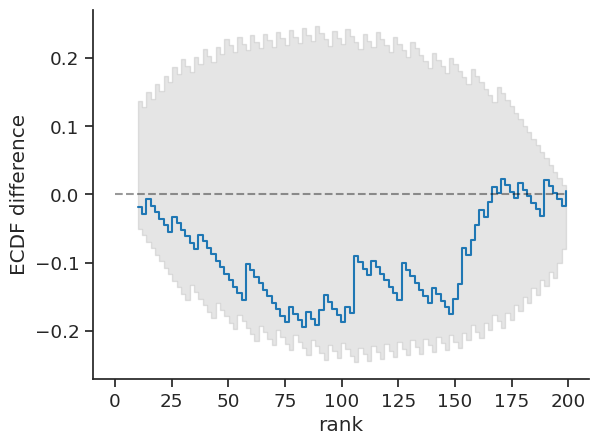

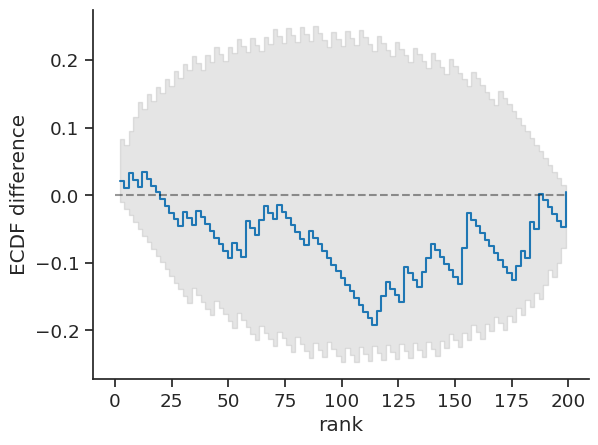

In [53]:
import arviz as az
from scipy import stats
max_rank  =200
pdf = stats.uniform(0,max_rank)
for par in dd.keys():
    ax = az.plot_ecdf(dd[par], cdf = pdf.cdf, difference=True, plot_kwargs={}, fill_kwargs={'color': 'grey'})
    ax.set_xlabel('rank')
    ax.set_ylabel('ECDF difference')
    ax.plot([0]*max_rank, ls='--', color='black', alpha=0.4)

In [13]:
sampler_kwargs={
    'chains': 1,
   # 'iter_warmup': 600,
    #'iter_sampling': 1000,
    'save_warmup': True, 
   # 'max_treedepth': 11
    'inits': {'m_red': 0.001, 'z': 0, 'bkg': 0.004, 'FWHM': 6},
    'adapt_delta':0.95,
    'show_progress': False
    #'show_console': True
}
N_fit=100

def Ho_fit(max_m):
    s = SpectraSampler({'$^{163}Ho$': [probability.HoSpectrum, [m, Q], A_Ho]}, flat_bkg=bkg, f_pileup=pu, FWHM=FWHM, dE=1, integrate=False, ROI=ROI)
    s.set_measure_time(n_days, n_det=n_det)
    events = s.sample()[0]
    pars = ['m_nu', 'Q', 'f_bkg', 'FWHM']
    data={'N_bins': len(events), 
      'N_window': 51,
      'x': s.ROI_bin_edges, 
      'counts': events,
      'N_ev': s.n_events,
      'p_Q': 2838,
      'p_FWHM': FWHM,
      'prior': 0,
      'm_max': max_m
    }
    div = 1
    while div!=0:
      fit = model.sample(data, **sampler_kwargs)
      div = sum(fit.divergences)
      print('there were ',div,' divergent transitions')
    return fit

df = multithreaded_run(Ho_fit,  [300]*N_fit, 32)


Number of events in ROI:  5930
Number of events in ROI:  5930
Number of events in ROI:  5930
Number of events in ROI:  5930
Number of events in ROI:  5930
Number of events in ROI:  5930
Number of events in ROI:  5930
Number of events in ROI:  5930
Number of events in ROI:  5930
Number of events in ROI:  5930
Number of events in ROI:  5930
Number of events in ROI:  5930
Number of events in ROI:  5930
Number of events in ROI:  5930
Number of events in ROI:  5930
Number of events in ROI:  5930
Number of events in ROI:  5930
Number of events in ROI:  5930
Number of events in ROI:  5930
Number of events in ROI:  5930
Number of events in ROI:  5930
Number of events in ROI:  5930
Number of events in ROI:  5930
Number of events in ROI:  5930
Number of events in ROI:  5930
Number of events in ROI:  5930
Number of events in ROI:  5930
Number of events in ROI:  5930
Number of events in ROI:  5930
Number of events in ROI:  5930
Number of events in ROI:  5930
Number of events in ROI:  5930
        

/home/pietro/.virtualenvs/baynesenv/lib/python3.10/site-packages/seaborn/categorical.py:3201: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)


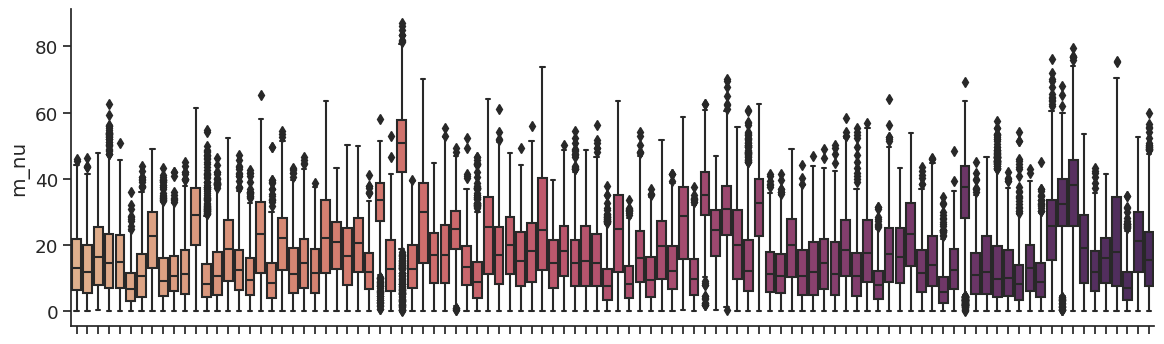

In [62]:
N_fit=100
p = FitPlotter(col_wrap=2, output_dir="/home/pietro/work/TESI/thesis/figures/ch3/endpoint/", output_format='.pdf')
for i, f in enumerate(df):
    p.add_fit(f, fit_title=str(N_fit-i))

ax = p.cat_plot(fit_titles='all', parameters='m_nu', x='fit', y='value', palette='flare')
ax = p.get_current_figure().axes[0]
ax.set_ylabel('m_nu')
ax.set_xlabel('')
ax.set_xticklabels([])
p.resize(17, 5)

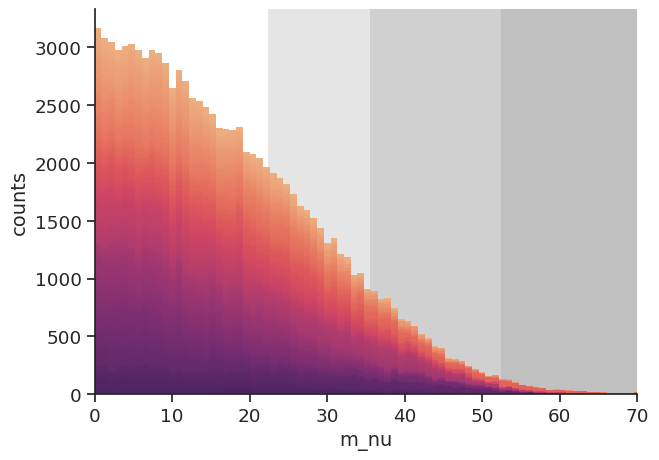

In [66]:

d = p.draws_df(fit_titles='all', parameters=['m_nu'])
full = d['m_nu'].to_numpy()
ax = p.new_figure('robust').subplots()
x_max=70

probs = [0.68, 0.9, 0.99]
limits = defaultdict(list)
for pr in probs:
    lim = np.percentile(full, pr*100)
    limits['CL (%)'].append(pr*100)
    limits['limit (eV)'].append(lim)
    ax.axvspan(lim, x_max, color='gray', alpha=0.2, lw=0)

sns.histplot(d, bins=100, x='m_nu', hue='fit', alpha=1, multiple='stack', legend=False, lw=0., palette='flare', ax=ax)
ax.set_xlim(0, x_max)
ax.set_xlabel('m_nu', fontsize=14)
ax.set_ylabel('counts', fontsize=14)
p.resize(7, 5)

In [67]:
print(pd.DataFrame.from_dict(limits).to_latex(index=False, float_format="%.2f"))

\begin{tabular}{rr}
\toprule
 CL (\%) &  limit (eV) \\
\midrule
  68.00 &       22.37 \\
  90.00 &       35.55 \\
  99.00 &       52.37 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_89649/3915244532.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.DataFrame.from_dict(limits).to_latex(index=False, float_format="%.2f"))


In [65]:
p.save_figures('all')

/home/pietro/.virtualenvs/baynesenv/lib/python3.10/site-packages/baynes/toyMC.py:139: RuntimeWarning: invalid value encountered in divide
  self.weights_in_ROI = weights_in_ROI / sum(weights_in_ROI)
/home/pietro/.virtualenvs/baynesenv/lib/python3.10/site-packages/baynes/toyMC.py:141: RuntimeWarning: invalid value encountered in divide
  self.binned_pdf = binned_pdf / sum(binned_pdf)


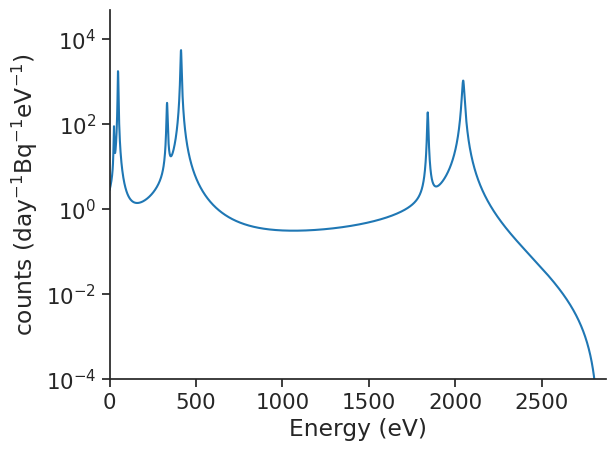

In [ ]:
s = SpectraSampler({'$^{163}Ho$': [probability.HoSpectrum, [0, 2833], 1]}, flat_bkg=0, FWHM=0, dE=1, integrate=False, ROI=[2890, 2900])
fig, ax =plt.subplots()
ax.plot(s.full_spectrum)
ax.set_yscale('log')
ax.set_xlim(0, 2870)
ax.set_ylim(1e-4, 5e4)
ax.set_xlabel('Energy (eV)')
ax.set_ylabel('counts (day$^{-1}$Bq$^{-1}$eV$^{-1}$)')
plt.savefig('Ho.pdf')

Number of events in ROI:  72
Number of events in ROI:  90
Number of events in ROI:  85
Number of events in ROI:  94
Number of events in ROI:  109
Number of events in ROI:  80
Number of events in ROI:  94
Number of events in ROI:  102
Number of events in ROI:  91
Number of events in ROI:  81
Number of events in ROI:  120
Number of events in ROI:  105
Number of events in ROI:  106
Number of events in ROI:  109
Number of events in ROI:  87
Number of events in ROI:  77
Number of events in ROI:  81
Number of events in ROI:  106
Number of events in ROI:  106
Number of events in ROI:  91
Number of events in ROI:  62
Number of events in ROI:  92
Number of events in ROI:  97
Number of events in ROI:  88
Number of events in ROI:  76
Number of events in ROI:  98
Number of events in ROI:  110
Number of events in ROI:  110
Number of events in ROI:  78
Number of events in ROI:  117
Number of events in ROI:  72
Number of events in ROI:  90
Number of events in ROI:  100
Number of events in ROI:  101
N

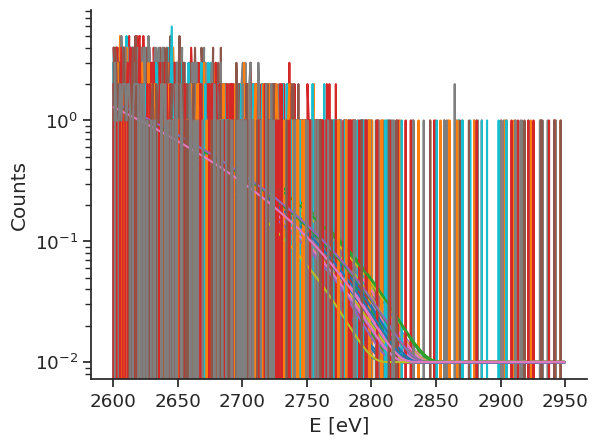

In [8]:
import numpy as np
m = 0
Q = 2833
A_Ho = 1
bkg = 1e-4
pu = 1.5e-6
FWHM=6.8
n_det = 64
n_days = 100

Qs=[]
FWHMs=[]
N_evs=[]
events = []
syst=[]
E_H = [2047, 1842, 414.2, 333.5, 49.9, 26.3]

data=defaultdict(list)
fig, ax = plt.subplots()
for i in range(n_det):
    E_shift = np.random.normal(0, 10)
    FWHM=np.random.normal(6.8, 1)

    s = SpectraSampler({'$^{163}Ho$': [probability.HoSpectrum, [m, Q+E_shift, [E+E_shift for E in E_H]], np.random.normal(1,0.1)]}, flat_bkg=bkg, f_pileup=pu, FWHM=FWHM, dE=1, integrate=False, ROI=[2600, 2950])
    s.set_measure_time(n_days, n_det=1)

    events.append(s.sample()[0])
    data['N_ev'].append(s.n_events)
    data['FWHM'].append(FWHM)
    syst.append(E_shift)
    s.plot_events(events[-1], ax=ax)
ax.get_legend().remove()

data.update({'N_bins': len(events[1]), 
      'N_det': n_det,
      'x': s.ROI_bin_edges, 
      'counts': events,
      'counts1': events[0],
      'p_Q': 2833,
      'm_max':250,

})
#true_pars = [m, Q, s.weights_in_ROI[2], s.weights_in_ROI[1], s.sigma]

Found .stan file  /home/pietro/work/TESI/baynes/stan/models/163Ho/endpoint_multidet/Ho_endpoint_multidet.stan

 ---- Sampling the priors ---- 


 ---- Prior predictive check ---- 



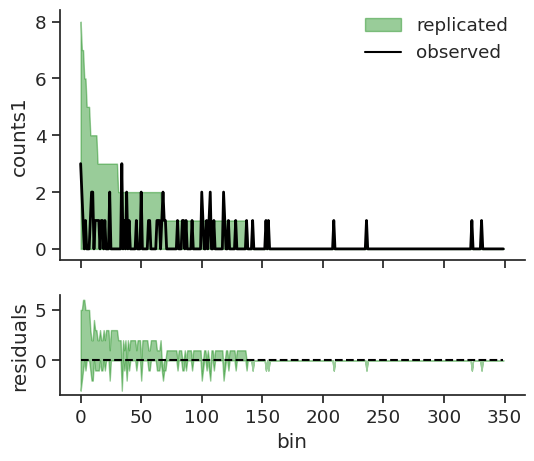


 ---- Prior distributions ---- 



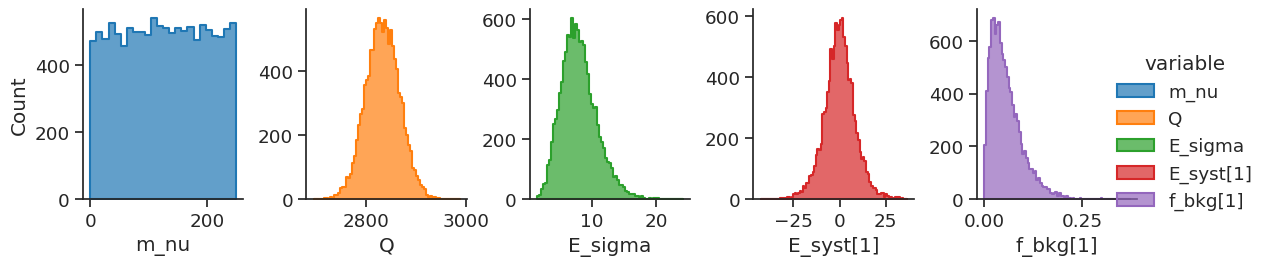


 ---- Fitting the model ---- 



chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 5 |          | 00:00 Status

chain 6 |          | 00:00 Status

chain 7 |          | 00:00 Status

chain 8 |          | 00:00 Status

chain 9 |          | 00:00 Status

chain 10 |          | 00:00 Status

chain 11 |          | 00:00 Status

chain 12 |          | 00:00 Status

chain 13 |          | 00:00 Status

chain 14 |          | 00:00 Status

chain 15 |          | 00:00 Status

chain 16 |          | 00:00 Status

chain 17 |          | 00:00 Status

chain 18 |          | 00:00 Status

chain 19 |          | 00:00 Status

chain 20 |          | 00:00 Status

chain 21 |          | 00:00 Status

chain 22 |          | 00:00 Status

chain 23 |          | 00:00 Status

chain 24 |          | 00:00 Status

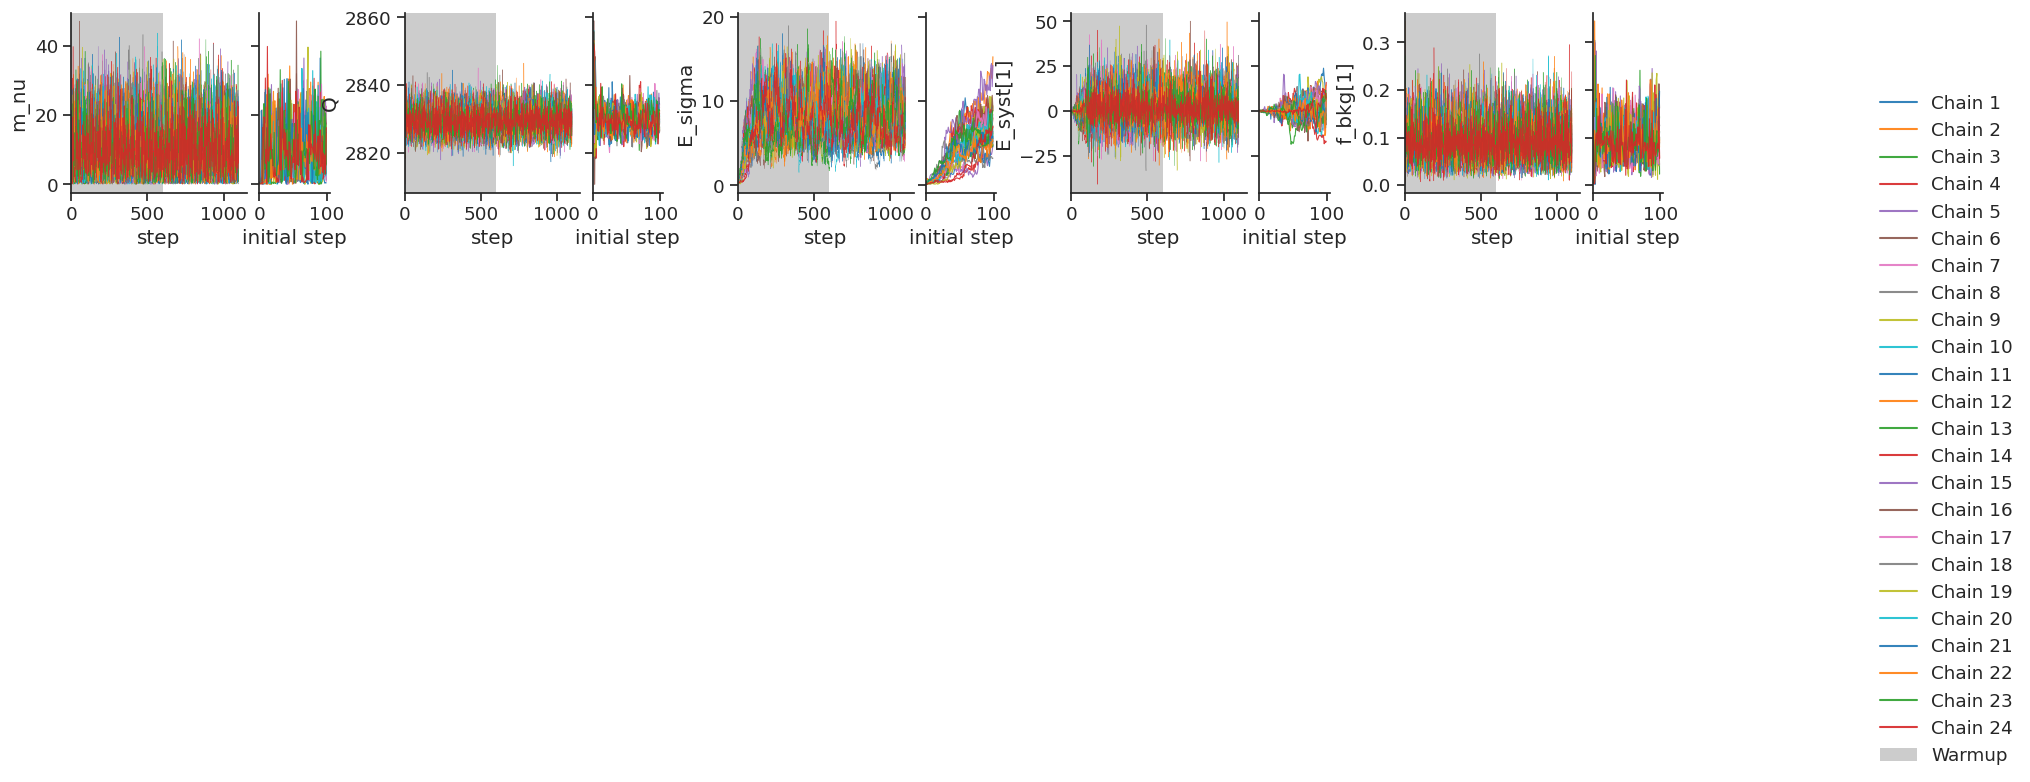


 ---- Posterior predictive check ---- 



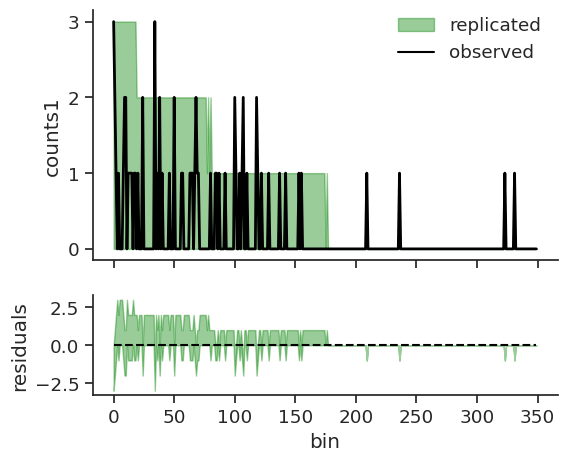


 ---- Posterior distributions ---- 



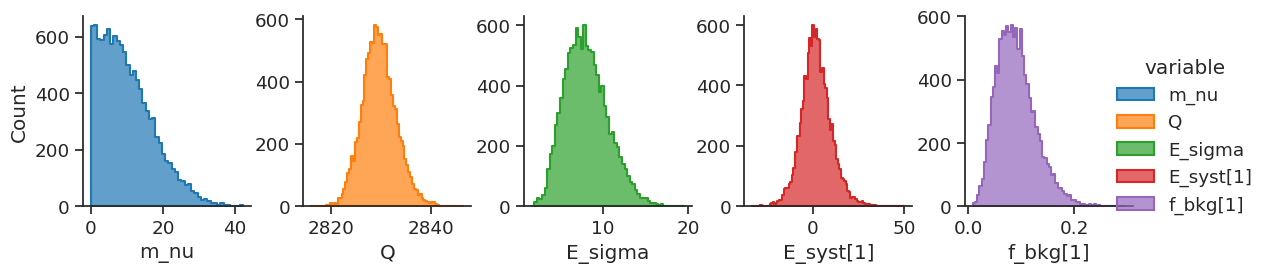


 ---- Prior vs posterior comparison ---- 



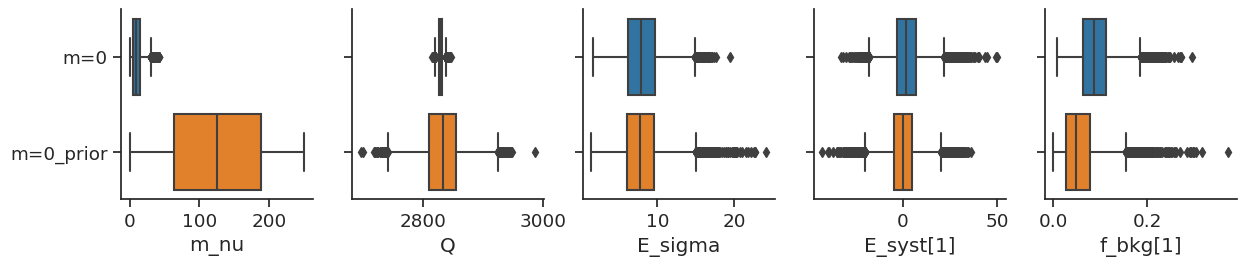

In [9]:
stan_file= get_stan_file("Ho_endpoint_multidet.stan")
multi_model = CmdStanModel(stan_file=stan_file,
                     **get_compiler_kwargs())



sampler_kwargs={
    'chains': 24,
    'iter_warmup': 600,
    'iter_sampling': 500,
    'save_warmup': True, 
    'adapt_delta': 0.95,
    'inits': {'m_red': 0.001, 'z': 0, 'f_bkg': [0.004]*n_det, 'E_sigma':1, 'E_syst':[0]*n_det},

}

pars=['m_nu', 'Q', 'E_sigma', 'E_syst[1]', 'f_bkg[1]']
p = FitPlotter(col_wrap=8)
fit = standard_analysis(multi_model, data, p, sampler_kwargs, fit_title='m=0', data_key='counts1', rep_key='counts1_rep', plot_params=pars)

In [10]:
fit.save_csvfiles(dir='/home/pietro/work/TESI/baynes/data/endpoint/64det/')

In [13]:
import arviz as az 

In [15]:
fit.draws_pd()

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,m_red,z,E_sigma,...,counts1_rep[341],counts1_rep[342],counts1_rep[343],counts1_rep[344],counts1_rep[345],counts1_rep[346],counts1_rep[347],counts1_rep[348],counts1_rep[349],counts1_rep[350]
0,-9317.34,0.976735,0.033328,7.0,127.0,0.0,9384.10,0.037137,-0.039974,6.43202,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,-9322.71,0.998047,0.033328,7.0,127.0,0.0,9379.89,0.030326,-0.263493,7.39205,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-9334.30,0.958479,0.033328,7.0,127.0,0.0,9402.73,0.034851,-0.253986,6.18374,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-9349.48,0.975934,0.033328,7.0,127.0,0.0,9418.67,0.040332,-0.037468,8.65360,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-9338.78,0.991547,0.033328,7.0,127.0,0.0,9414.69,0.048990,-0.105872,8.78831,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,-9292.30,0.999215,0.060551,6.0,63.0,0.0,9352.15,0.059461,-0.029729,4.41743,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11996,-9296.20,0.997258,0.060551,6.0,63.0,0.0,9359.30,0.024297,-0.112960,4.54386,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11997,-9288.21,0.956520,0.060551,6.0,63.0,0.0,9361.64,0.030004,-0.165558,4.41890,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11998,-9300.33,0.949809,0.060551,6.0,63.0,0.0,9350.98,0.090478,-0.021323,4.83206,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
p.fits

{'m=0_prior': CmdStanMCMC: model=Ho_endpoint_multidet chains=24['method=sample', 'num_samples=500', 'num_warmup=600', 'save_warmup=1', 'algorithm=hmc', 'adapt', 'engaged=1', 'delta=0.95']
  csv_files:
 	/tmp/tmpt_m6mzab/Ho_endpoint_multidet5e8ofd3n/Ho_endpoint_multidet-20231003193213_1.csv
 	/tmp/tmpt_m6mzab/Ho_endpoint_multidet5e8ofd3n/Ho_endpoint_multidet-20231003193213_2.csv
 	/tmp/tmpt_m6mzab/Ho_endpoint_multidet5e8ofd3n/Ho_endpoint_multidet-20231003193213_3.csv
 	/tmp/tmpt_m6mzab/Ho_endpoint_multidet5e8ofd3n/Ho_endpoint_multidet-20231003193213_4.csv
 	/tmp/tmpt_m6mzab/Ho_endpoint_multidet5e8ofd3n/Ho_endpoint_multidet-20231003193213_5.csv
 	/tmp/tmpt_m6mzab/Ho_endpoint_multidet5e8ofd3n/Ho_endpoint_multidet-20231003193213_6.csv
 	/tmp/tmpt_m6mzab/Ho_endpoint_multidet5e8ofd3n/Ho_endpoint_multidet-20231003193213_7.csv
 	/tmp/tmpt_m6mzab/Ho_endpoint_multidet5e8ofd3n/Ho_endpoint_multidet-20231003193213_8.csv
 	/tmp/tmpt_m6mzab/Ho_endpoint_multidet5e8ofd3n/Ho_endpoint_multidet-2023100319

In [20]:
results = az.from_cmdstanpy(posterior=fit, prior=p.fits['m=0_prior'], observed_data=data)

In [21]:
file_path = "/home/pietro/work/TESI/baynes/data/endpoint/64results.json"
az.to_json(results, file_path)

'/home/pietro/work/TESI/baynes/data/endpoint/64results.json'

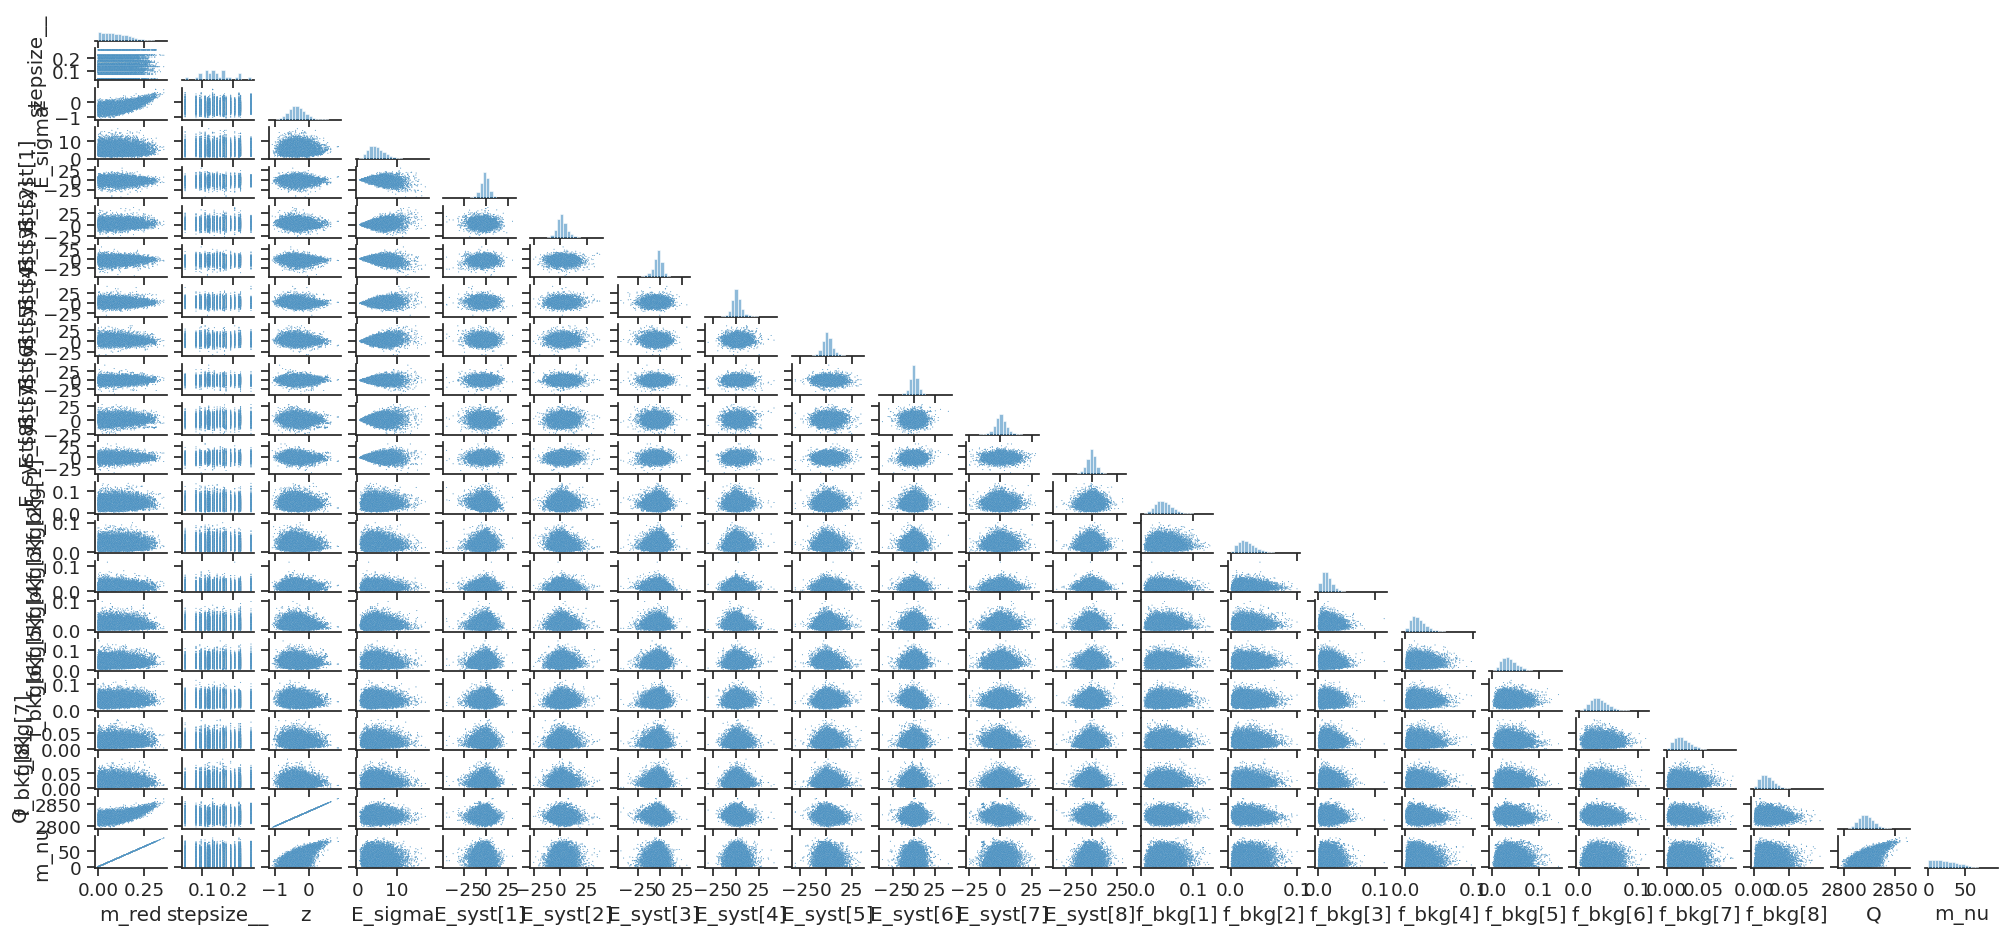

In [4]:
p.pair_grid()

Found .stan file  /home/pietro/work/TESI/baynes/stan/models/163Ho/endpoint_multidet/Ho_endpoint_multidet.stan

 ---- Sampling the priors ---- 


 ---- Prior predictive check ---- 



/home/pietro/.virtualenvs/baynesenv/lib/python3.10/site-packages/baynes/plotter.py:546: RuntimeWarning: invalid value encountered in divide
  ax1.fill_between(np.arange(len(events)), (lo-events)/np.sqrt(events), (hi-events)/np.sqrt(events),
/home/pietro/.virtualenvs/baynesenv/lib/python3.10/site-packages/baynes/plotter.py:546: RuntimeWarning: divide by zero encountered in divide
  ax1.fill_between(np.arange(len(events)), (lo-events)/np.sqrt(events), (hi-events)/np.sqrt(events),


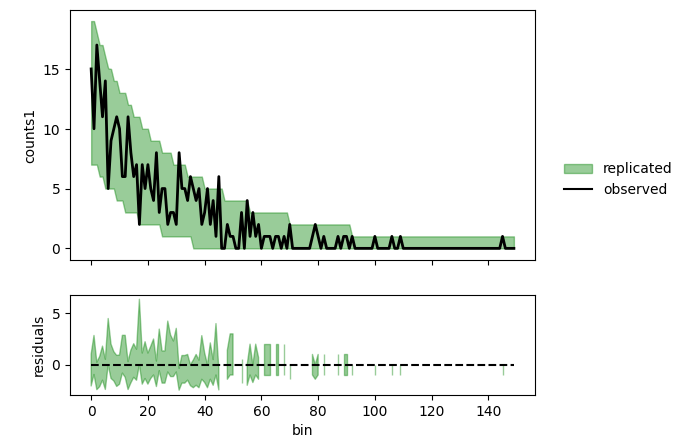


 ---- Prior distributions ---- 



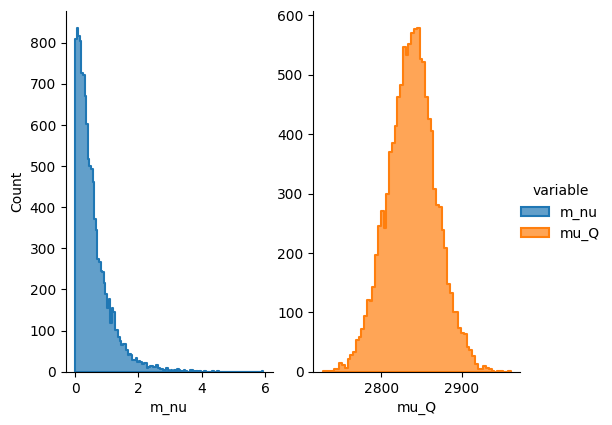


 ---- Fitting the model ---- 



chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 5 |          | 00:00 Status

chain 6 |          | 00:00 Status

chain 7 |          | 00:00 Status

chain 8 |          | 00:00 Status

chain 9 |          | 00:00 Status

chain 10 |          | 00:00 Status

chain 11 |          | 00:00 Status

chain 12 |          | 00:00 Status

chain 13 |          | 00:00 Status

chain 14 |          | 00:00 Status

chain 15 |          | 00:00 Status

chain 16 |          | 00:00 Status

chain 17 |          | 00:00 Status

chain 18 |          | 00:00 Status

chain 19 |          | 00:00 Status

chain 20 |          | 00:00 Status

chain 21 |          | 00:00 Status

chain 22 |          | 00:00 Status

chain 23 |          | 00:00 Status

chain 24 |          | 00:00 Status

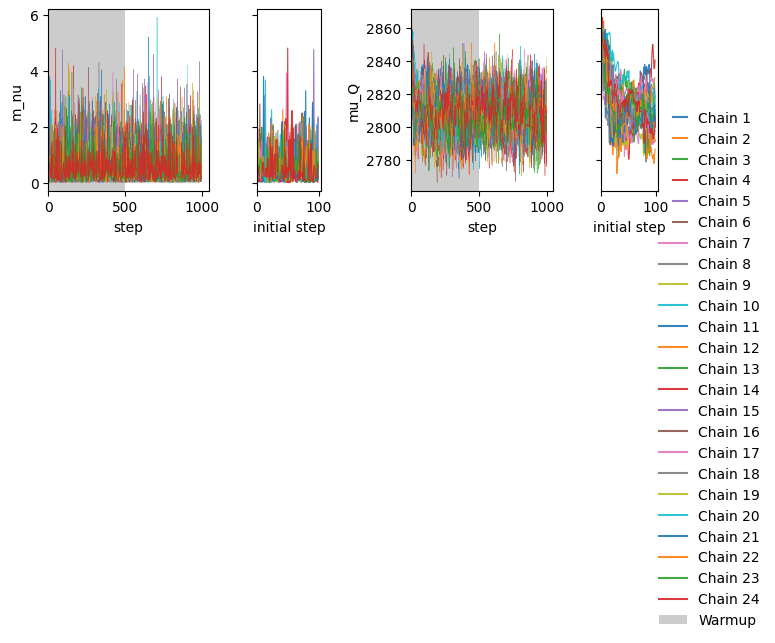


 ---- Posterior predictive check ---- 



/home/pietro/.virtualenvs/baynesenv/lib/python3.10/site-packages/baynes/plotter.py:546: RuntimeWarning: invalid value encountered in divide
  ax1.fill_between(np.arange(len(events)), (lo-events)/np.sqrt(events), (hi-events)/np.sqrt(events),
/home/pietro/.virtualenvs/baynesenv/lib/python3.10/site-packages/baynes/plotter.py:546: RuntimeWarning: divide by zero encountered in divide
  ax1.fill_between(np.arange(len(events)), (lo-events)/np.sqrt(events), (hi-events)/np.sqrt(events),


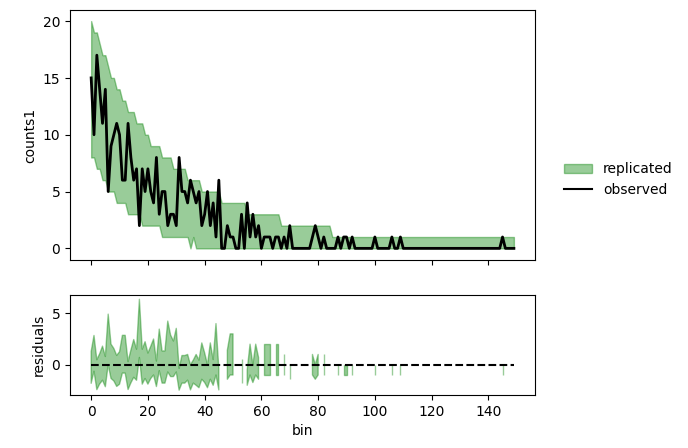


 ---- Posterior distributions ---- 



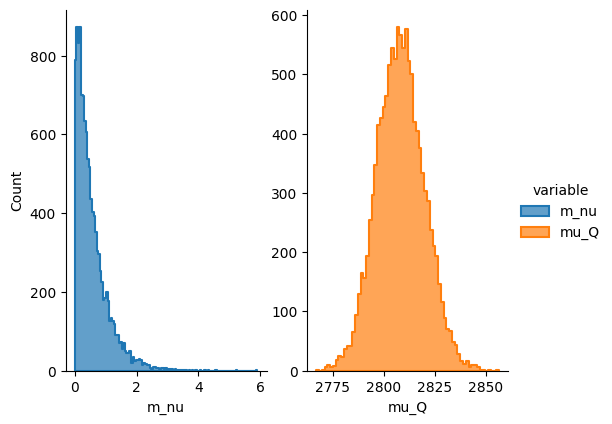


 ---- Prior vs posterior comparison ---- 



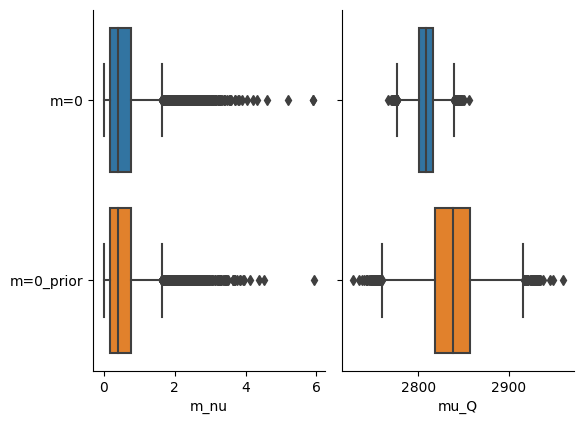

In [ ]:
stan_file= get_stan_file("Ho_endpoint_multidet.stan")
pileup_model = CmdStanModel(stan_file=stan_file,
                     **get_compiler_kwargs())

data={'N_bins': len(events[1]), 
      'N_det': n_det,
      'N_window': 51,
      'x': s.ROI_bin_edges, 
      'counts': events,
      'counts1': events[0],
      'N_ev': N_evs,
      'p_Q': 2838,
      'p_FWHM': FWHM,
}

sampler_kwargs={
    'chains': 24,
    'iter_warmup': 500,
    'iter_sampling': 500,
    'save_warmup': True, 
    'adapt_delta': 0.9
}

pars=['m_nu', 'mu_Q']
p = FitPlotter(col_wrap=8)
fit = standard_analysis(pileup_model, data, p, sampler_kwargs, fit_title='m=0', data_key='counts1', plot_params=pars)

In [ ]:
fit.summary().loc['mu_Q']

Mean       2808.09183
MCSE          0.28231
StdDev       11.58297
5%         2789.37000
50%        2807.91000
95%        2827.31000
N_Eff      1683.44532
N_Eff/s       3.32544
R_hat         1.00799
Name: mu_Q, dtype: float64

(array([900., 827., 758., 696., 639., 556., 520., 469., 444., 421., 338.,
        335., 271., 257., 242., 196., 192., 202., 149., 145., 141., 120.,
        102.,  99.,  86.,  77.,  67.,  59.,  71.,  53.,  54.,  58.,  40.,
         35.,  27.,  31.,  28.,  18.,  25.,  28.,  12.,  15.,  13.,  12.,
         15.,  13.,  13.,  11.,   9.,  13.,  13.,   9.,   5.,   6.,   1.,
          7.,   4.,   7.,   6.,   3.,   7.,   3.,   3.,   4.,   2.,   2.,
          1.,   1.,   1.,   0.,   0.,   0.,   2.,   0.,   0.,   0.,   1.,
          0.,   1.,   1.,   0.,   1.,   1.,   1.,   1.,   1.,   1.,   0.,
          1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([2.99889533e-05, 1.58498441e-02, 3.16696993e-02, 4.74895544e-02,
        6.33094096e-02, 7.91292648e-02, 9.49491199e-02, 1.10768975e-01,
        1.26588830e-01, 1.42408685e-01, 1.58228541e-01, 1.74048396e-01,
        1.89868251e-01, 2.05688106e-01, 2.21507961e-01, 2.37327816e-01,
        2.53147672e-01, 2.6896

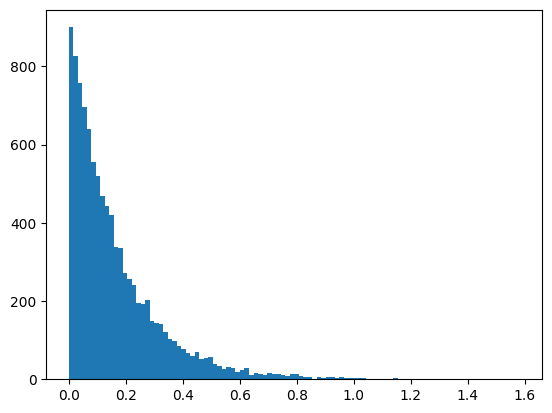

In [ ]:
plt.hist(np.random.gamma(1.135, 1/2.302 , 10000), bins=100)

In [ ]:
from scipy import stats


Number of events in ROI:  239538


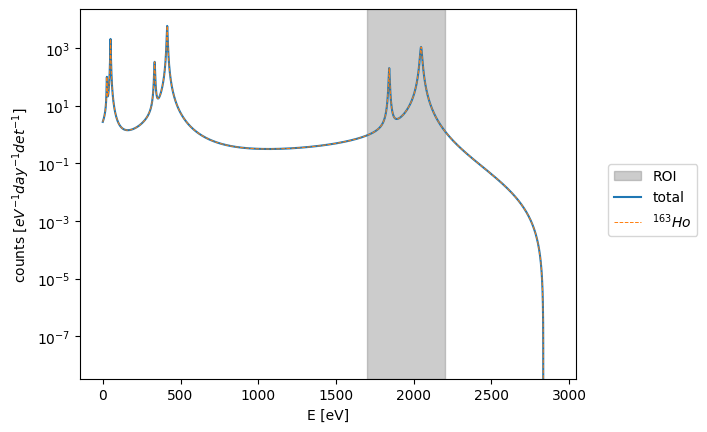

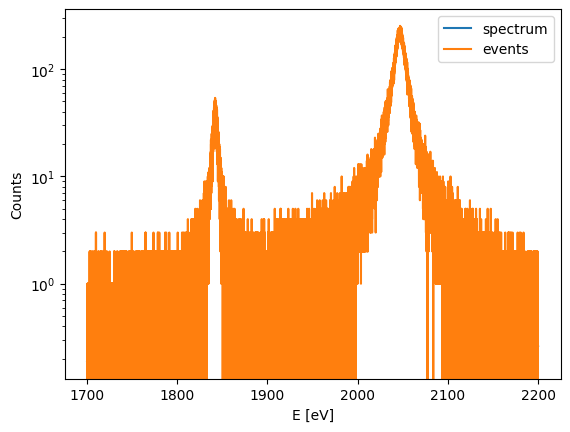

In [ ]:
m = 1
Q = 2833.8
A_Ho = 1
bkg = 0
pu = 0
FWHM=5
n_days = 10

s = SpectraSampler({'$^{163}Ho$': [probability.HoSpectrum, [m, Q], A_Ho]}, FWHM=0, dE=0.02, integrate=False, ROI=[1700, 2200])
s.plot_spectrum()
s.set_measure_time(n_days, n_det=1)

events = s.sample()[0]
s.plot_events(events)

true_pars = [m, Q, s.FWHM]

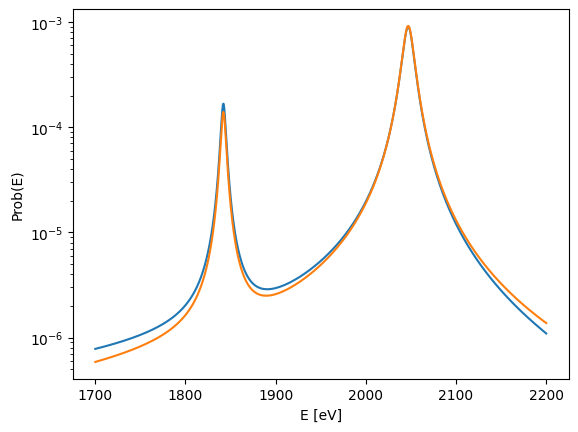

In [ ]:
s = SpectraSampler({'$^{163}Ho$': [probability.HoSpectrum, [m, Q], A_Ho]}, FWHM=0, dE=0.02, integrate=False, ROI=[1700, 2200])
ax = s.plot_pdf()
s.update_spectrum({'$^{163}Ho$': [probability.HoSpectrum, [m, 3500], A_Ho]})
ax = s.plot_pdf(ax=ax)

In [ ]:
evs = []
bins=s.ROI_bin_centers
for i, ev in enumerate(events):
    if ev!=0:
        evs = evs + [bins[i]] * ev
len(evs)

238756

In [ ]:
max(evs)

2199.91

In [ ]:
stan_file= get_stan_file("Ho_endpoint_unbinned.stan")
pileup_model = CmdStanModel(stan_file=stan_file,
                     **get_compiler_kwargs())

evs=s.ROI_bin_centers[np.nonzero(events)]
data={'N_ev': len(evs), 
      'events': evs,
      'p_Q': 3138,
      'dx': 1,
      'p_FWHM': FWHM,
      'prior': 0
}

sampler_kwargs={
    'chains': 8,
    'iter_warmup': 500,
    'iter_sampling': 500,
    'save_warmup': True, 
    'show_console': False,
    #'adapt_delta': 0.9,
    'inits':{'Q':2838, 'FWHM':3, 'EM': 2000}#, 'mu_ev':2000, 'sigma_ev': 50}
}
p = FitPlotter(col_wrap=3)
fit = pileup_model.sample(data, **sampler_kwargs)
print(fit.diagnose())
p.add_fit(fit)

plot_params=['m_nu', 'Q', 'FWHM', 'EM']#, 'mu_ev', 'sigma_ev']
p.convergence_plot(plot_params)
p.dis_plot(plot_params, kind="hist", hue="variable", common_bins=False, element="step", alpha=0.7, lw=1.5)


Found .stan file  /home/pietro/work/TESI/baynes/stan/models/163Ho/endpoint_simple/Ho_endpoint_unbinned.stan


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 5 |          | 00:00 Status

chain 6 |          | 00:00 Status

chain 7 |          | 00:00 Status

chain 8 |          | 00:00 Status